In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../dataset/KEY.csv')
df1=df.reset_index()['Close']

In [3]:
df1.describe()

count    3375.000000
mean       14.278945
std         4.808535
min         5.710000
25%         9.885000
50%        13.640000
75%        18.290001
max        27.010000
Name: Close, dtype: float64

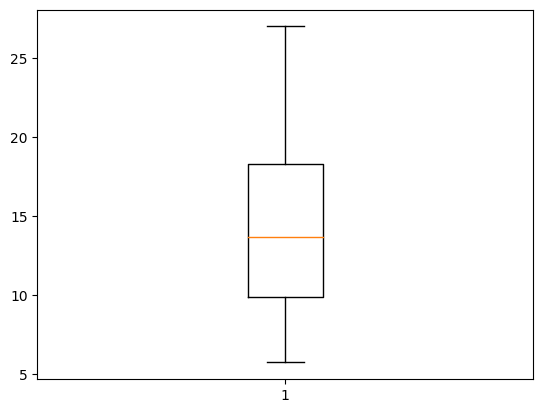

In [4]:
# Creating plot
plt.boxplot(df1)
 
# show plot
plt.show()

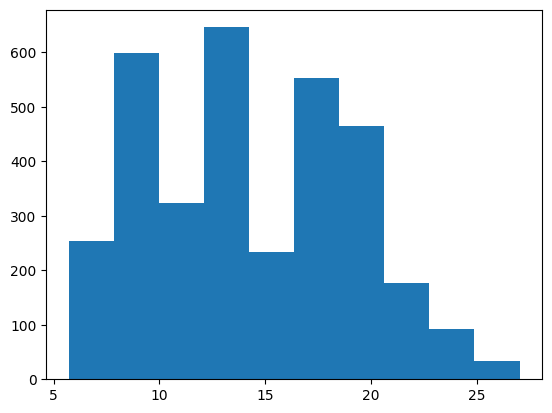

In [5]:
# Creating Histogram
plt.hist(df1)
 
# show Histogram
plt.show()

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [11]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
41/41 [==============================] - 2s 20ms/step - loss: 0.0112 - val_loss: 0.0072
Epoch 2/100
41/41 [==============================] - 1s 14ms/step - loss: 8.2719e-04 - val_loss: 0.0020
Epoch 3/100
41/41 [==============================] - 1s 13ms/step - loss: 5.7261e-04 - val_loss: 0.0013
Epoch 4/100
41/41 [==============================] - 1s 14ms/step - loss: 4.8530e-04 - val_loss: 0.0013
Epoch 5/100
41/41 [==============================] - 1s 14ms/step - loss: 4.2768e-04 - val_loss: 0.0014
Epoch 6/100
41/41 [==============================] - 1s 19ms/step - loss: 3.9085e-04 - val_loss: 0.0013
Epoch 7/100
41/41 [==============================] - 1s 16ms/step - loss: 3.7600e-04 - val_loss: 0.0011
Epoch 8/100
41/41 [==============================] - 1s 15ms/step - loss: 3.4411e-04 - val_loss: 0.0015
Epoch 9/100
41/41 [==============================] - 1s 13ms/step - loss: 3.3695e-04 - val_loss: 7.2097e-04
Epoch 10/100
41/41 [==============================] - 1s 14ms/st

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

8/8 [==============================] - 0s 5ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [15]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1) )
yval = scaler.inverse_transform(yval.reshape(-1,1) )

In [16]:
# 12. Đánh giá độ chính xác thuật toán
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval)) * 100
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 0.5111581627499959
Testing RMSE: 0.4251108011412427
Validation MAE: 0.3400114731331999
Testing MAE: 0.33930290727880436
Validation MAPE: 2.27833483035239
Testing MAPE: 1.5661020250091782


In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=277
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.70046944 0.66666667 0.6643193  0.67230052 0.63849761 0.64600934
 0.65727695 0.68403761 0.66056343 0.64929582 0.63239437 0.62018779
 0.60422535 0.60187798 0.60610333 0.60187798 0.63427225 0.60093897
 0.59389676 0.59201878 0.62159629 0.62629103 0.64835681 0.66713615
 0.66244131 0.66901404 0.64741784 0.66713615 0.65399056 0.65492958
 0.65774643 0.63896714 0.60751174 0.56619718 0.54835676 0.55539911
 0.56478873 0.53380282 0.54225352 0.55446009 0.54929577 0.53004695
 0.56901408 0.55633798 0.55868549 0.55305164 0.54084507 0.55352113
 0.54788728 0.54178404 0.55915498 0.55305164 0.54929577 0.54460089
 0.52957746 0.51267601 0.55446009 0.56291085 0.57934268 0.58356803
 0.58920188 0.57887329 0.58169014 0.55962437 0.57793427 0.57276995
 0.59107977 0.59061038 0.57605634 0.58215967 0.56478873 0.57981216
 0.58403756 0.58215967 0.61784042 0.63380277 0.64319249 0.64507047
 0.66056343 0.64460099 0.65399056 0.63802812 0.61032859 0.61314554
 0.61220657 0.62676052 0.5971831  0.57746479 0.570

0 day output [[0.18034492]]
1 day input [0.66666667 0.6643193  0.67230052 0.63849761 0.64600934 0.65727695
 0.68403761 0.66056343 0.64929582 0.63239437 0.62018779 0.60422535
 0.60187798 0.60610333 0.60187798 0.63427225 0.60093897 0.59389676
 0.59201878 0.62159629 0.62629103 0.64835681 0.66713615 0.66244131
 0.66901404 0.64741784 0.66713615 0.65399056 0.65492958 0.65774643
 0.63896714 0.60751174 0.56619718 0.54835676 0.55539911 0.56478873
 0.53380282 0.54225352 0.55446009 0.54929577 0.53004695 0.56901408
 0.55633798 0.55868549 0.55305164 0.54084507 0.55352113 0.54788728
 0.54178404 0.55915498 0.55305164 0.54929577 0.54460089 0.52957746
 0.51267601 0.55446009 0.56291085 0.57934268 0.58356803 0.58920188
 0.57887329 0.58169014 0.55962437 0.57793427 0.57276995 0.59107977
 0.59061038 0.57605634 0.58215967 0.56478873 0.57981216 0.58403756
 0.58215967 0.61784042 0.63380277 0.64319249 0.64507047 0.66056343
 0.64460099 0.65399056 0.63802812 0.61032859 0.61314554 0.61220657
 0.62676052 0.5971831 

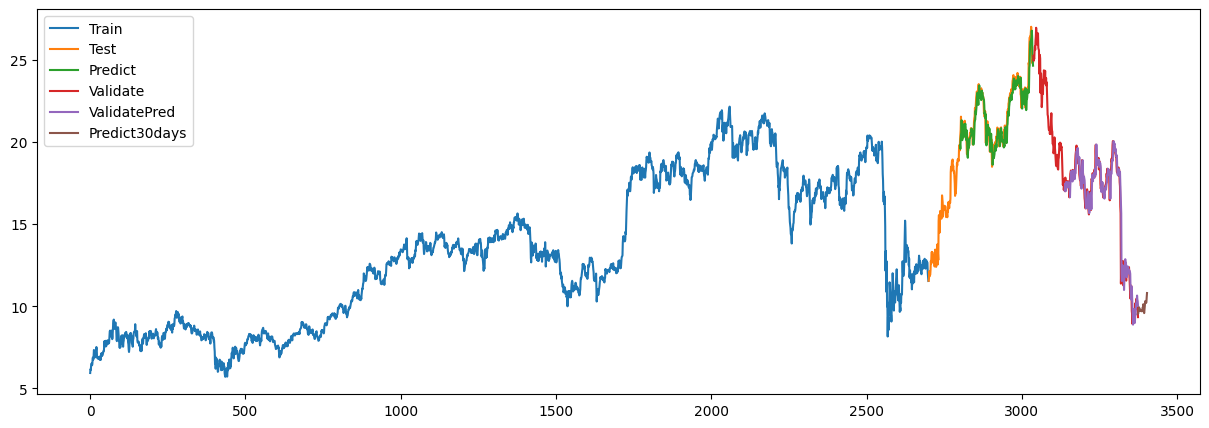

In [18]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.subplots(figsize=(15, 5))
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [19]:
scaler.inverse_transform(lst_output)

array([[ 9.55134689],
       [ 9.57949187],
       [ 9.79904237],
       [ 9.93949811],
       [ 9.90221153],
       [ 9.76709786],
       [ 9.74632406],
       [ 9.80106862],
       [ 9.70796786],
       [ 9.77699804],
       [ 9.77681109],
       [ 9.71715041],
       [ 9.69276814],
       [ 9.71838285],
       [ 9.76657448],
       [ 9.92988296],
       [ 9.90589236],
       [10.12424819],
       [ 9.87290362],
       [ 9.63797248],
       [ 9.58293592],
       [ 9.82027418],
       [10.02916625],
       [10.28752144],
       [10.3262966 ],
       [10.31495418],
       [10.2015646 ],
       [10.24981748],
       [10.54559605],
       [10.8067478 ]])